# CPS2.2 - Computer Problem Set 2.2
### **Girsanov Theorem**

In [87]:
import numpy as np
import matplotlib.pyplot as plt

## 1 - Monte Carlo Approximation of $\Delta_0$ using $\Delta_0 = P[S_T\ge K]$

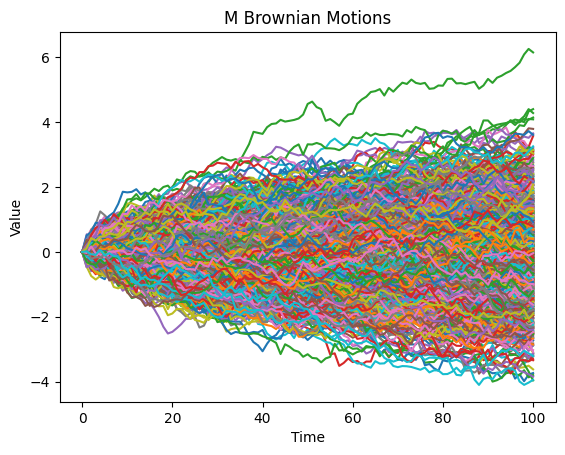

In [88]:
M = 1000
S0 = 100
r = 0.02
sigma = 0.4
T = 2
n = 100

# Creating our M Brownian Motions 
def create_W(M,n,T):
    W = np.zeros((n+1,M))
    dt = T/n
    W[1:n+1,:] = np.sqrt(dt)*np.random.randn(n,M)
    W = np.cumsum(W,axis=0)
    return W

# Plotting the Brownian Motions for verification
plt.figure()
plt.plot(create_W(M,n,T))
plt.title('M Brownian Motions')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()


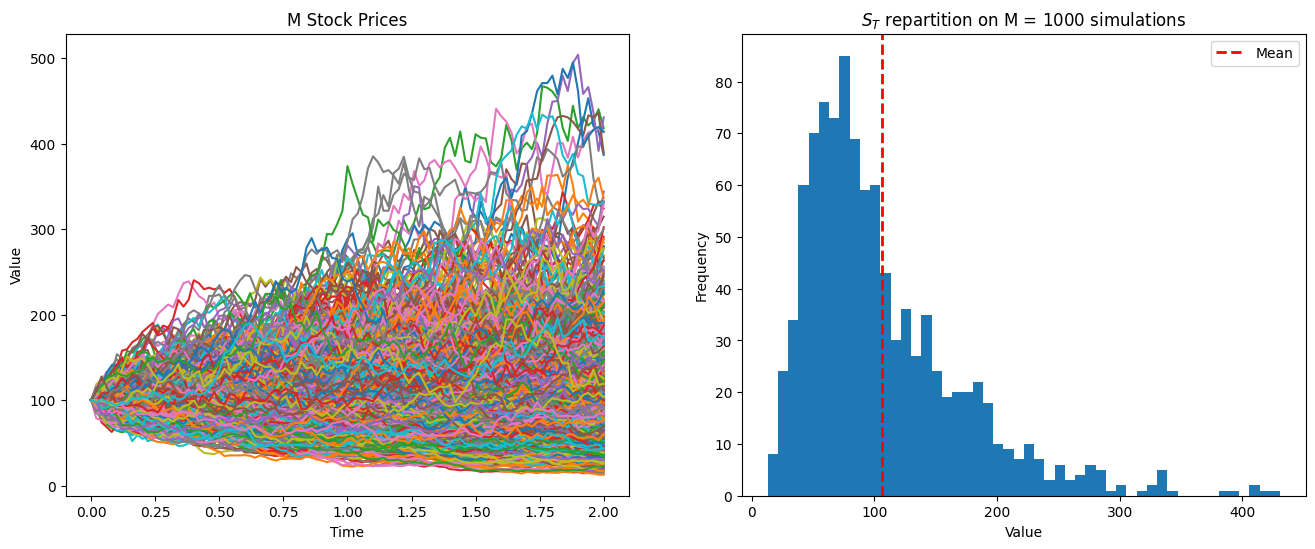

The mean of the final stock price is : 106.12357284745553


In [89]:
def create_S(M,n,T,r,sigma):
    S = np.zeros((n+1,M))
    dt = T/n
    W = create_W(M,n,T)
    S[0,:] = S0
    for i in range(1,n+1):
        S[i,:] = S[i-1,:] + S[i-1,:]*(r*T/n + sigma * (W[i,:] - W[i-1,:]))
    return S,W

S,W = create_S(M,n,T,r,sigma)

# Plotting the M Stock Prices
plt.figure(12,figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(np.linspace(0,T,n+1),S)
plt.title('M Stock Prices')
plt.xlabel('Time')
plt.ylabel('Value')

# Plotting S(T) for verification
plt.subplot(1,2,2)
plt.hist(S[-1,:] , bins = 50)

# Plotting the mean axis
plt.axvline(np.mean(S[-1,:]), color='r', linestyle='dashed', linewidth=2)
plt.title('$S_T$ repartition on M = 1000 simulations')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend(['Mean'])
plt.show()

print('The mean of the final stock price is :',np.mean(S[-1,:]))


In [90]:
def monte_carlo(M,n,T,r,sigma,K):
    S,W = create_S(M,n,T,r,sigma)
    count = np.sum(S[-1,:]>K)
    return count/M

K = 150
print('The probability that the stock price is above K = 150 is : Delta_0 = ',monte_carlo(M,n,T,r,sigma,K))

The probability that the stock price is above K = 150 is : Delta_0 =  0.172


## 2 - Monte Carlo Approximation of $\Delta_0$ using $\Delta_0 = E^{Q^{\theta}}[ (Z^{\theta})^{-1} \mathbb{1}_{\{S_T \geq K\}}]$

In [98]:
def create_Z_theta(M,n,T,r,sigma,theta):
    S,W = create_S(M,n,T,r,sigma)
    Z = np.zeros(M)
    for i in range(M):
        Z[i] = np.exp(theta*W[-1,i]-(theta**2)*T/2)
    return Z,S

def monte_carlo_theta(M,n,T,r,sigma,K,theta):
    Z,S = create_Z_theta(M,n,T,r,sigma,theta)
    out = 0
    for i in range(M):
        if S[-1,i] >= K:
            out +=  1/Z[i] * 
    return out/M

K = 150
theta = -2
print("The approximation of Delta_0 with theta = 0.5 is : ",monte_carlo_theta(M,n,T,r,sigma,K,theta))

The approximation of Delta_0 with theta = 0.5 is :  2687.807988495148


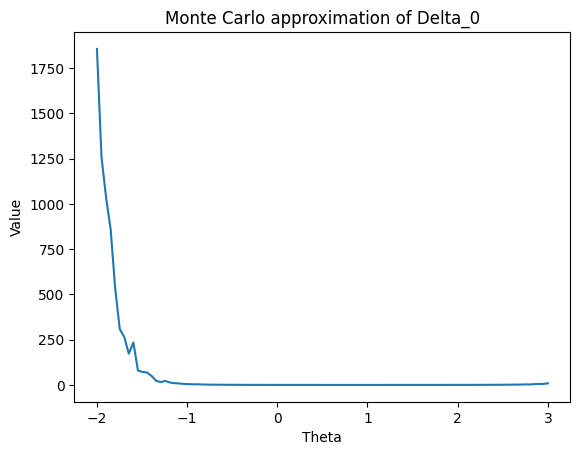

In [101]:


range_theta = np.linspace(-2,3,100)
plt.figure()
plt.plot(range_theta,[monte_carlo_theta(M,n,T,r,sigma,K,theta) for theta in range_theta])
plt.title('Monte Carlo approximation of Delta_0')
plt.xlabel('Theta')
plt.ylabel('Value')
plt.show()
